Exercise 2.5 (programming) Design and conduct an experiment to demonstrate the </br>
difficulties that sample-average methods have for nonstationary problems. Use a modified </br>
version of the 10-armed testbed in which all the q⇤(a) start out equal and then take</br>
independent random walks (say by adding a normally distributed increment with mean </br>
zero and standard deviation 0.01 to all the q⇤(a) on each step). Prepare plots like</br>
Figure 2.2 for an action-value method using sample averages, incrementally computed,</br>
and another action-value method using a constant step-size parameter, a = 0.1. Use </br>
eps = 0.1 and longer runs, say of 10,000 steps.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# initialize rewards
def assign_mean_rewards(n_actions, mean, variance):
    return np.random.normal(mean, variance, size=n_actions)

def assign_equal_rewards(n_actions):
    return np.zeros(n_actions)

In [ ]:
# calculate reward
def get_reward(true_rewards, action, variance):
    reward_mean = true_rewards[action]
    return np.random.normal(reward_mean, variance)

def get_drifting_reward(true_rewards, action):
    """Drift all the rewards"""
    n = len(true_rewards)
    drifted_rewards = true_rewards + np.random.normal(0, 0.01, size=n)
    return drifted_rewards, true_rewards[action]

In [ ]:
# policies
def epsilon_greedy(qtable, n_actions, epsilon):
    if np.random.random() < epsilon:
        return np.random.randint(0, n_actions)
    else:
        return np.argmax(qtable)

def ucb(qtable:np.ndarray, counts:np.ndarray, timestamp:int, exploration_rate:float):
    # argmax(qtable + c * ((ln(timestamp) / n)**0.5) )
    # first try all actions once
    zero_mask = (counts == 0)
    if zero_mask.any():
        # pick the first untried action
        a = int(np.flatnonzero(zero_mask)[0])
        counts[a] += 1
        return a, counts
    
    uncertainty = (np.log(timestamp+1) / counts)**0.5
    chosen_action  = int(
        np.argmax(qtable + exploration_rate * uncertainty)
    )
    counts[chosen_action] += 1

    return chosen_action, counts

In [ ]:
# qtable updates

def update_estimate_average(qtable, true_reward, action, timestamp):
    current_estimate = qtable[action]
    # update our reward estimate by sample averaging
    updated_estimate = current_estimate + (true_reward - current_estimate) / (timestamp + 1)
    qtable[action] = updated_estimate
    return None

def update_estimate_alpha(qtable, true_reward, action, alpha):
    current_estimate = qtable[action]
    # update our reward estimate by alpha
    updated_estimate = current_estimate + alpha * (true_reward - current_estimate)
    qtable[action] = updated_estimate
    return None

def update_unbiased_constant(qtable, true_reward, action, timestamp, alpha):
    # formula to calculate trace at timestamp t: `1 + (1-alpha)^t  * (trace_0 - 1)`
    # where trace_0 is an initial constant trace value. In the textbook, it is set as 0 
    # which leaves us with the below formula:
    # 1 + (1-alpha) * (0-1) -> 1 + (1-alpha)^t * (-1) -> 1 - (1-alpha)^t
    trace = 1 - (1-alpha)**timestamp
    step_size = alpha / trace

    current_estimate = qtable[action]
    updated_estimate = current_estimate + step_size * (true_reward - current_estimate)
    qtable[action] = updated_estimate
    return None

In [ ]:
# plotting
def plot_run_results(rewards):
    plt.figure(figsize=(12, 7))
    plt.plot(
        np.arange(len(rewards)), rewards
    )
    plt.title("Rewards over time")
    plt.show()

def plot_many_run_results(title:str, **kwargs):
    plt.figure(figsize=(12, 7))
    
    first_col = list(kwargs.keys())[0]
    x_axis = np.arange(len(kwargs[first_col])) 
    
    for name, values in kwargs.items():
        plt.plot(
            x_axis, values, label=name
        )
    
    plt.title(title)
    plt.legend()
    plt.show()

In [4]:
def experiment(
        narms = 10,
        nruns = 2_000,
        eps = 0.01,
        alpha = 0.1,
        base_mean = 0,
        base_variance = 1,
        timestamps = 10_000,
        initial_reward = 0,
        policy='epsilon', # ucb, epsilon
        exploration_rate=None,

        ):
    
    total_rewards = []
    total_choices = []

    for n in range(nruns):
        # actual mean rewards for each action
        rewards_table = assign_mean_rewards(narms, base_mean, base_variance)
        
        # agent's estimate
        qtable = [initial_reward for _ in range(narms)]
        if policy == 'ucb':
            counts = np.zeros(narms)
        
        bandit_rewards = []
        optimal_action = []

        for i in range(timestamps):
            if policy == 'ucb':
                chosen_action, counts = ucb(qtable, counts, i, exploration_rate=exploration_rate)
            elif policy=='epsilon':
                chosen_action = epsilon_greedy(qtable, narms, eps)
            reward = get_reward(rewards_table, chosen_action, base_variance)
            update_estimate_alpha(qtable, reward, chosen_action, alpha)
            optimal_action.append(
                int(chosen_action == np.argmax(rewards_table))
            )
            bandit_rewards.append(reward)
        
        total_rewards.append(bandit_rewards)
        total_choices.append(optimal_action)
    
    return total_rewards, total_choices

In [5]:
def experiment_drifting(
        narms = 10,
        nruns = 2_000,
        eps = 0.01,
        alpha = 0.1,
        base_mean = 0,
        base_variance = 1,
        timestamps = 10_000):
    
    total_rewards = []
    total_choices = []


    for n in range(nruns):
        # actual mean rewards for each action
        rewards_table = assign_equal_rewards(narms)
        
        # agent's estimate
        qtable = np.zeros(narms)
        bandit_rewards = []
        optimal_action = []

        for i in range(timestamps):
            chosen_action = epsilon_greedy(qtable, narms, eps)
            rewards_table, reward = get_drifting_reward(rewards_table, chosen_action)
            
            update_estimate_average(qtable, reward, chosen_action, i)

            optimal_action.append(
                int(chosen_action == np.argmax(rewards_table))
            )
            bandit_rewards.append(reward)
        
        total_rewards.append(bandit_rewards)
        total_choices.append(optimal_action)
    return total_rewards, total_choices

In [6]:
narms = 10
nruns = 2_000
eps = 0.1
alpha = 0.1

# gaussian distribution
base_mean = 0
base_variance = 1
timestamps = 1_000
initial_reward = 5

In [7]:
epsilon_01 = experiment(
    narms=narms,
    nruns=nruns,
    eps=0.1,
    alpha=alpha,
    base_mean=base_mean,
    base_variance=base_variance,
    timestamps=timestamps,
    policy='ucb',
    exploration_rate=2
    # initial_reward=initial_reward 
)

In [8]:
epsilon_001 = experiment(
    narms=narms,
    nruns=nruns,
    eps=0.01,
    alpha=alpha,
    base_mean=base_mean,
    base_variance=base_variance,
    timestamps=timestamps,
    policy='ucb',
    exploration_rate=2
    # initial_reward =initial_reward 
)

In [9]:
epsilon_0 = experiment(
    narms=narms,
    nruns=nruns,
    eps=0.0,
    alpha=alpha,
    base_mean=base_mean,
    base_variance=base_variance,
    timestamps=timestamps,
    policy='ucb',
    exploration_rate=2
    # initial_reward =initial_reward 
)

In [10]:
mean_rewards = {}
sum_optimal_choices = {}

for exp_result, name in zip([epsilon_01, epsilon_001, epsilon_0], ['epsilon_01', 'epsilon_001', 'epsilon_0']):
    
    exp_mean_rewards = np.mean(exp_result[0], axis=0)
    exp_sum_optimal_choices = np.mean(exp_result[1], axis=0) * 100.0

    mean_rewards[name] = exp_mean_rewards
    sum_optimal_choices[name] = exp_sum_optimal_choices

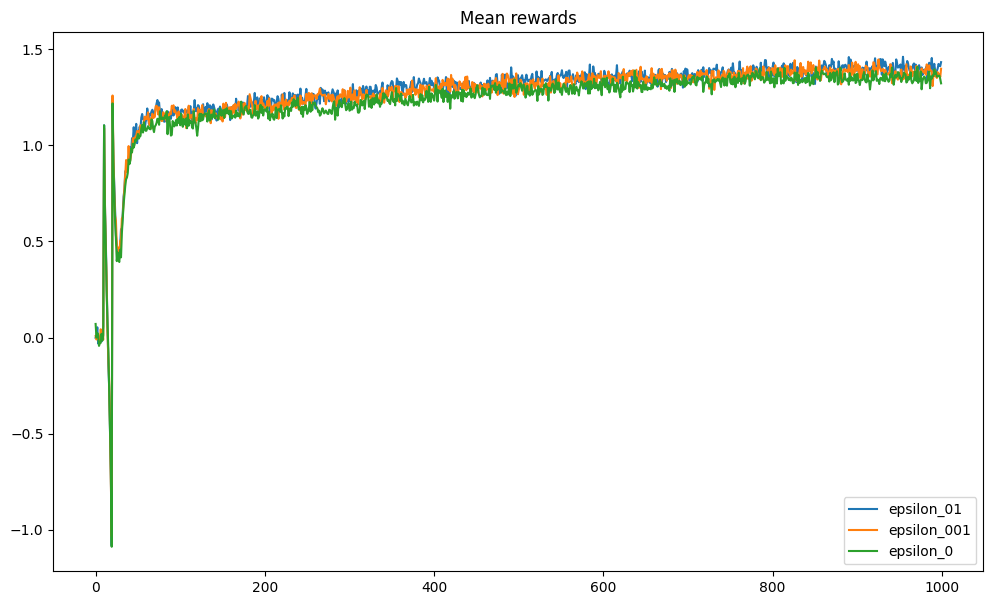

In [13]:
plot_many_run_results(title='Mean rewards', **mean_rewards)

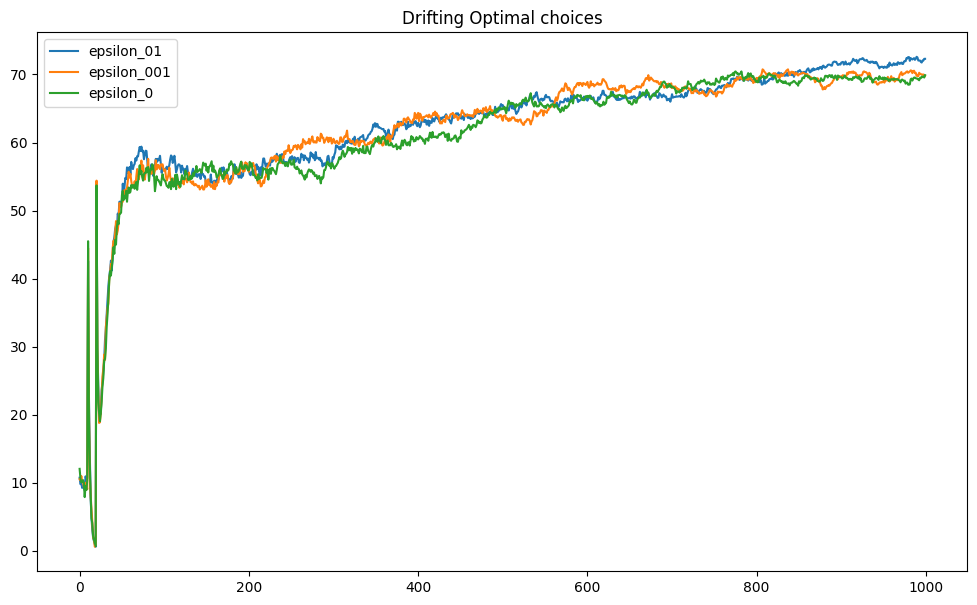

In [12]:
plot_many_run_results(title='Drifting Optimal choices', **sum_optimal_choices)